In [2]:
using Polyhedra
using JuMP
using LinearAlgebra
using Cbc
using GLPK
using Plots
using LaTeXStrings

In [3]:
include("utils.jl")

simulateTrajectories (generic function with 1 method)

In [4]:
# data of the problem
A=[1 0; 0 1]
B=[1 0; 0 1]
B=hcat(B) # to have a matrix and not a vector
C=[1 0; 0 1]
k=[0; 0]
N_m=1
N_c=2
T_max=5
alpha=3 # scaling of the safety set: alpha*hypercube

n_y,n_x=size(C)
_,n_u=size(B)

(2, 2)

In [5]:
time_beginning=time_ns()

model, C_bar, S = instantiateALAP(A,B,C,k,N_m,N_c,T_max,alpha);

time_ending=time_ns()
exec_time=(time_ending-time_beginning)/1e9
print("\n\n==== Instantiation time = $(exec_time) seconds ====\n\n")

Done.

In [6]:
set_optimizer(model, Cbc.Optimizer)

time_beginning=time_ns()

optimize!(model)

time_ending=time_ns()
exec_time=(time_ending-time_beginning)/1e9
print("\n\n==== Solving time = $(exec_time) seconds ====\n\n")

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Nov  9 2020 

command line - Cbc_C_Interface -solve -quit (default strategy 1)
Continuous objective value is 6 - 0.01 seconds
Cgl0004I processed model has 1353 rows, 1148 columns (22 integer (22 of which binary)) and 6636 elements
Cbc0012I Integer solution of -3 found by DiveCoefficient after 0 iterations and 0 nodes (0.06 seconds)
Cbc0038I Full problem 1353 rows 1148 columns, reduced to 1263 rows 1120 columns - 1 fixed gives 1118, 1084 - still too large
Cbc0012I Integer solution of -5 found by DiveCoefficient after 435 iterations and 0 nodes (0.17 seconds)
Cbc0031I 21 added rows had average density of 4.6666667
Cbc0013I At root node, 21 cuts changed objective from -6 to -6 in 9 passes
Cbc0014I Cut generator 0 (Probing) - 11 row cuts average 2.2 elements, 4 column cuts (4 active)  in 0.004 seconds - new frequency is 1
Cbc0014I Cut generator 1 (Gomory) - 1 row cuts average 13.0 elements, 0 column cuts (0 active)  in 0.003 seco

In [7]:
F, f, T_opt, sigma_meas_opt, sigma_control_opt = getResultsALAP(model,C_bar,S);
T_opt

4

In [8]:
for t=0:T_max-1
    for tau=0:t
        if !sigma_meas_opt[tau+1]
            print("No meas. ")
        else
            print("Meas.    ")
        end
        if !sigma_control_opt[t+1]
            print("No cont. ")
        else
            print("Cont.    ")
        end
        print("f($t)=$(f[:,t+1]) ---  F($t,$(tau))=$(F[:,:,t+1,tau+1]) \n")
    end
end

No meas. No cont. f(0)=[0.0, 0.0] ---  F(0,0)=[0.0 0.0; 0.0 0.0] 
No meas. No cont. f(1)=[0.0, 0.0] ---  F(1,0)=[0.0 0.0; 0.0 0.0] 
No meas. No cont. f(1)=[0.0, 0.0] ---  F(1,1)=[0.0 0.0; 0.0 0.0] 
No meas. Cont.    f(2)=[0.0, 0.0] ---  F(2,0)=[0.0 0.0; 0.0 0.0] 
No meas. Cont.    f(2)=[0.0, 0.0] ---  F(2,1)=[0.0 0.0; 0.0 0.0] 
Meas.    Cont.    f(2)=[0.0, 0.0] ---  F(2,2)=[-0.499999999981619 0.0; 0.0 -0.499999999981619] 
No meas. No cont. f(3)=[0.0, 0.0] ---  F(3,0)=[0.0 0.0; 0.0 0.0] 
No meas. No cont. f(3)=[0.0, 0.0] ---  F(3,1)=[0.0 0.0; 0.0 0.0] 
Meas.    No cont. f(3)=[0.0, 0.0] ---  F(3,2)=[-0.49999999998161904 0.0; 0.0 -0.49999999998161904] 
No meas. No cont. f(3)=[0.0, 0.0] ---  F(3,3)=[0.0 0.0; 0.0 0.0] 
No meas. Cont.    f(4)=[0.0, 0.0] ---  F(4,0)=[0.0 0.0; 0.0 0.0] 
No meas. Cont.    f(4)=[0.0, 0.0] ---  F(4,1)=[0.0 0.0; 0.0 0.0] 
Meas.    Cont.    f(4)=[0.0, 0.0] ---  F(4,2)=[0.0 0.0; 0.0 0.0] 
No meas. Cont.    f(4)=[0.0, 0.0] ---  F(4,3)=[0.0 0.0; 0.0 0.0] 
No meas. Con

In [9]:
x=simulateTrajectories(A,B,C,k,F,f;numberSamples=100);

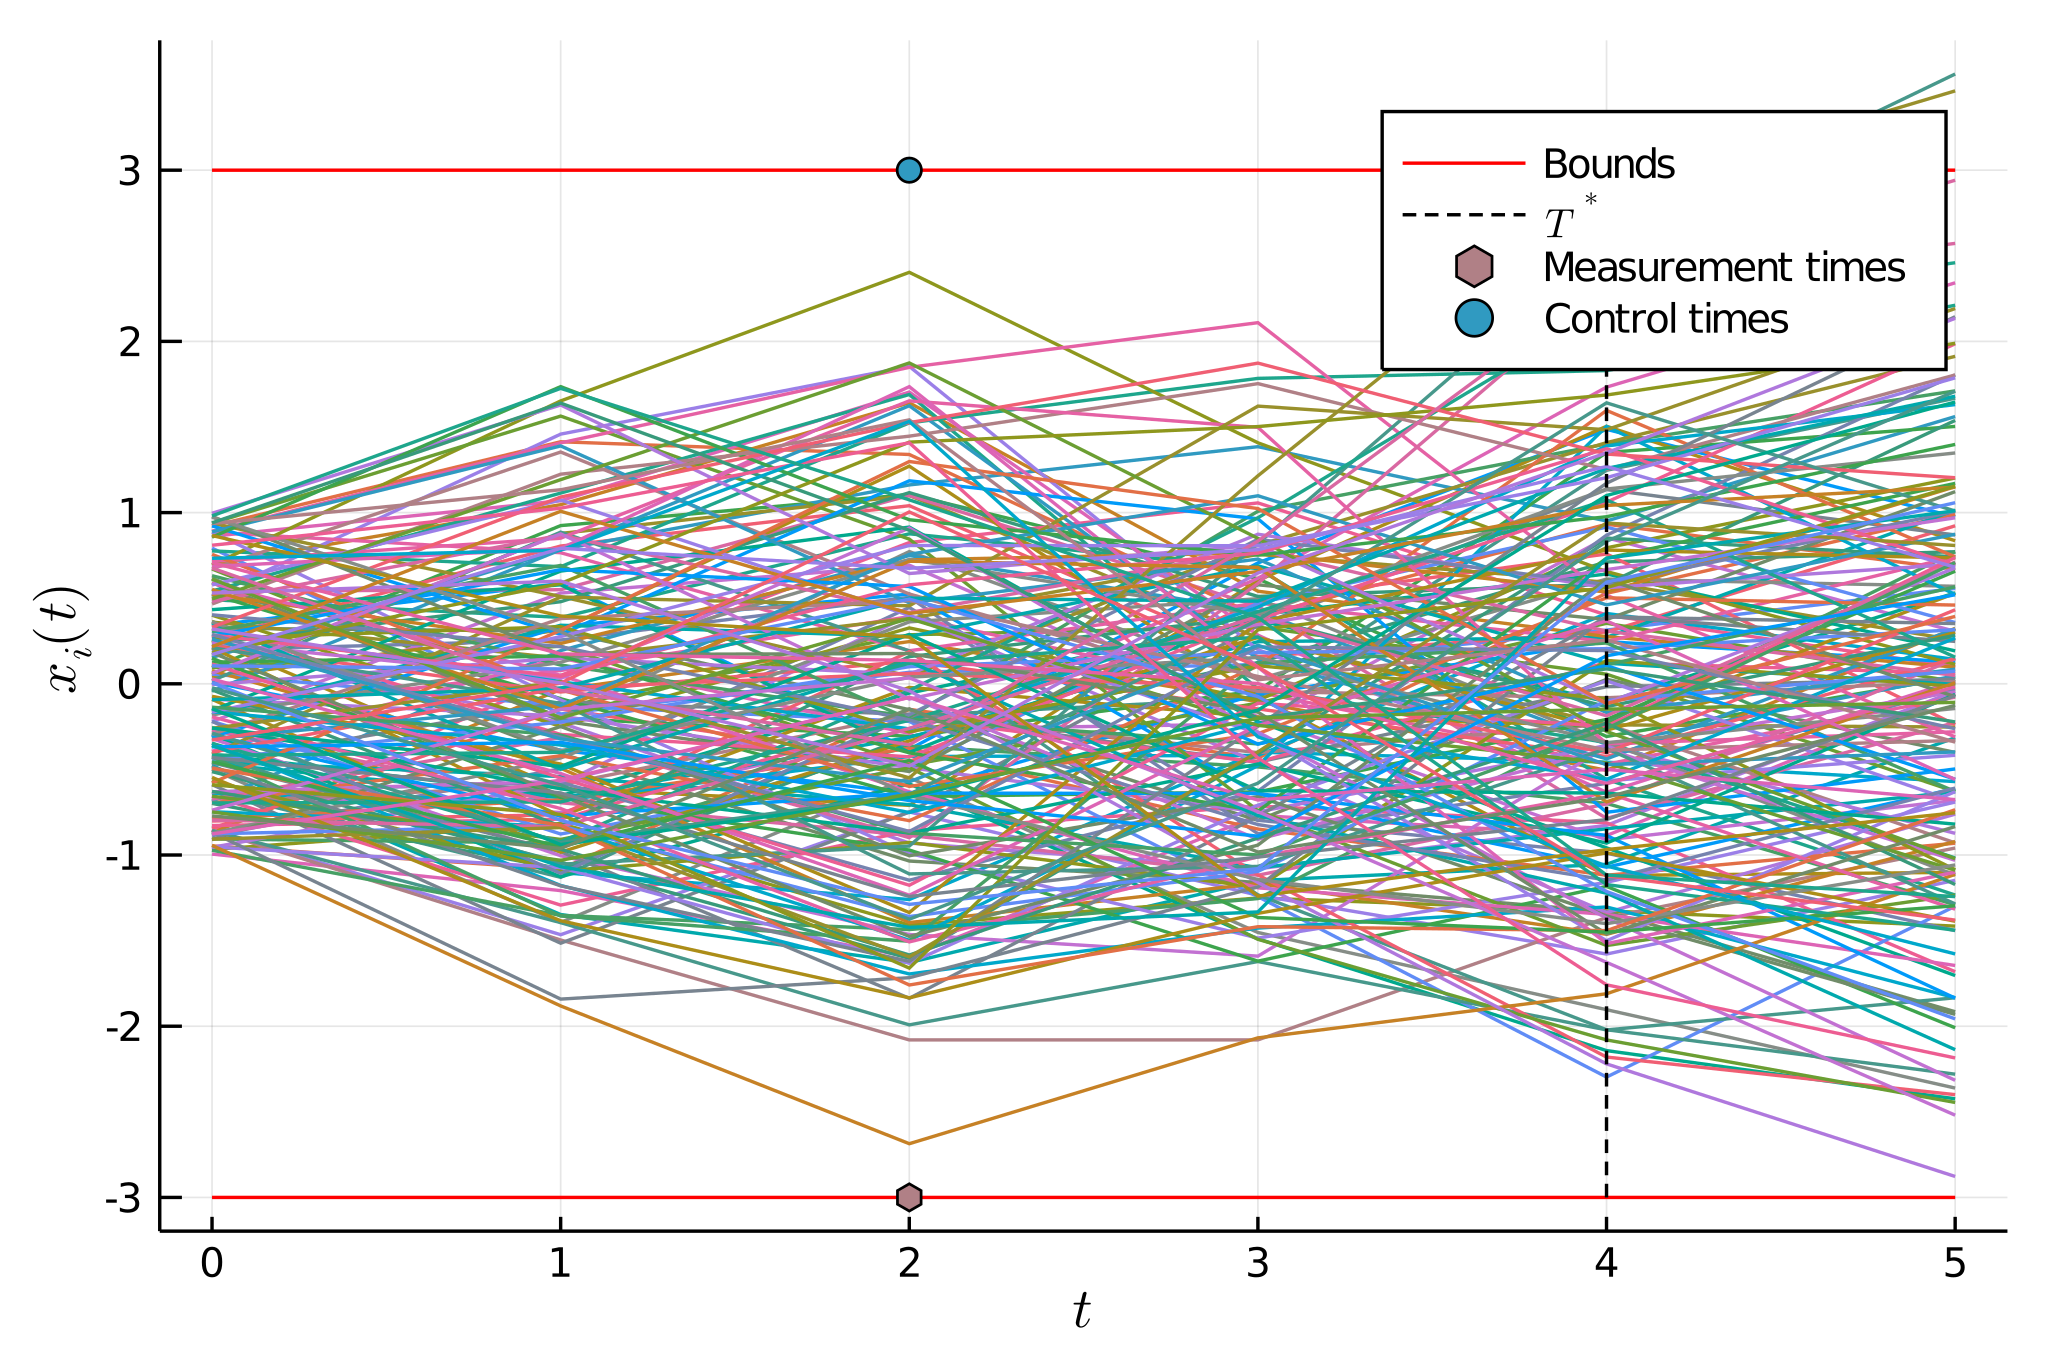

In [28]:
# plot trajectories
T=T_max
plot(0:T,x[:,1,:]',label=false)
plot!(0:T,x[:,2,:]',label=false)

xlabel!(L"t")
ylabel!(L"x_i(t)")

plot!(0:T,ones(T+1)*alpha,linecolor=:red, label="Bounds")
plot!(0:T,-ones(T+1)*alpha,linecolor=:red, label=false)

plot!([T_opt T_opt]',[-alpha alpha]',linecolor=:black,label=L"T^*",linestyle = :dash)

t_meas=findall(sigma_meas_opt.==1).-1
scatter!(t_meas,-alpha*ones(length(t_meas)),label="Measurement times",marker=:hexagon)

t_control=findall(sigma_control_opt.==1).-1
scatter!(t_control,alpha*ones(length(t_control)),label="Control times")
xticks!(0:T)

#plot!(size=(250,250))
savefig("FIGS/ALAP.pdf")
plot!()